In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-08-07 10:53:53.138735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/catarinavuzi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/Users/catarinavuzi/Downloads/cracked_uncracked_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


2024-08-07 10:54:38.255622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


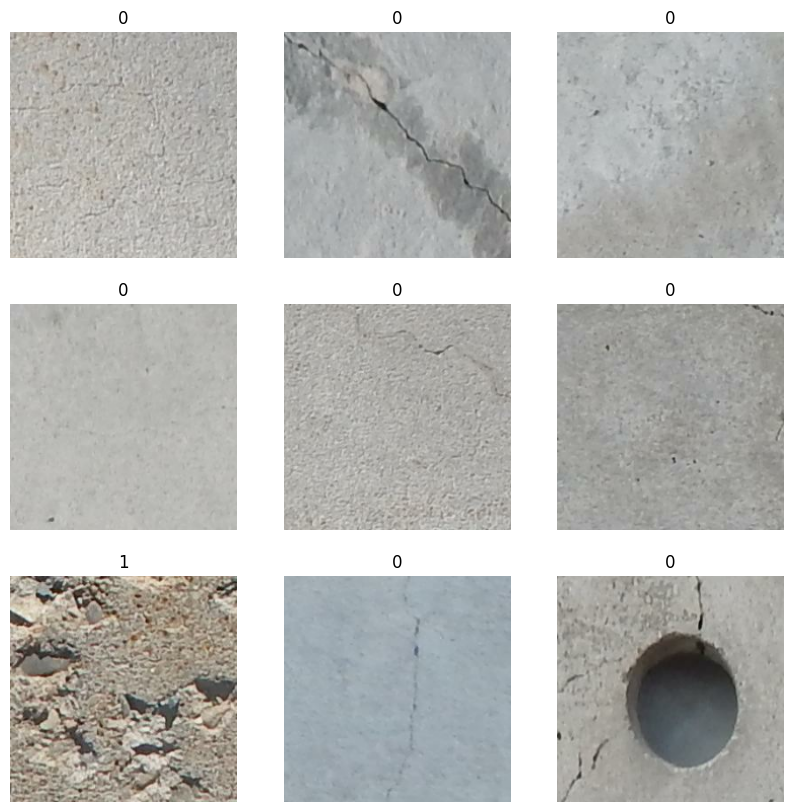

In [4]:
##Taking a look to the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-08-07 10:54:47.437134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


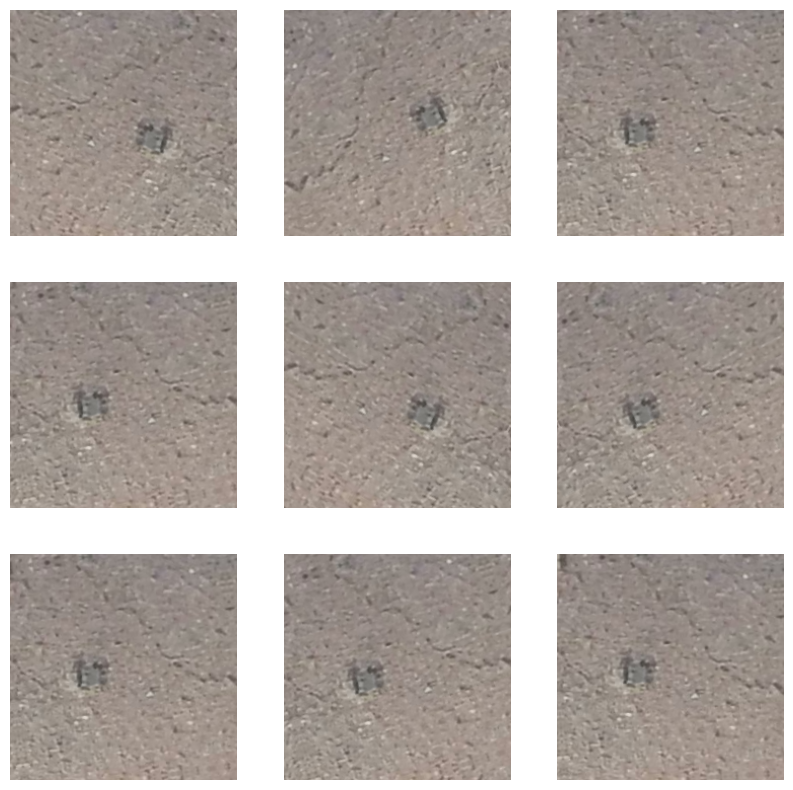

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [9]:
def make_model_1(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model_1(input_shape=image_size + (3,), num_classes=2)
##keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - acc: 0.4899 - loss: 0.9213 - val_acc: 0.5000 - val_loss: 0.6930
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - acc: 0.5620 - loss: 0.7478 - val_acc: 0.5000 - val_loss: 0.6930
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5711 - loss: 0.7294 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - acc: 0.6641 - loss: 0.6801 - val_acc: 0.5000 - val_loss: 0.6937
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5674 - loss: 0.6800 - val_acc: 0.5000 - val_loss: 0.6941
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - acc: 0.5740 - loss: 0.7666 - val_acc: 0.5000 - val_loss: 0.6944
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - acc: 0.6560 - loss: 0.6844 - val_acc: 0.5000 - val_loss: 0.6950
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - acc: 0.6465 - loss: 0.6917 - val_acc: 0.5000 - val_loss: 0.6946


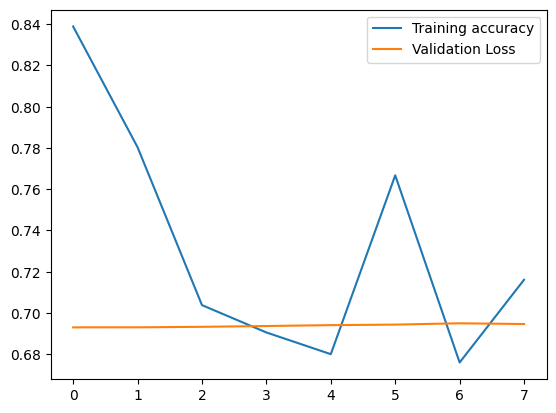

In [11]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training accuracy")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

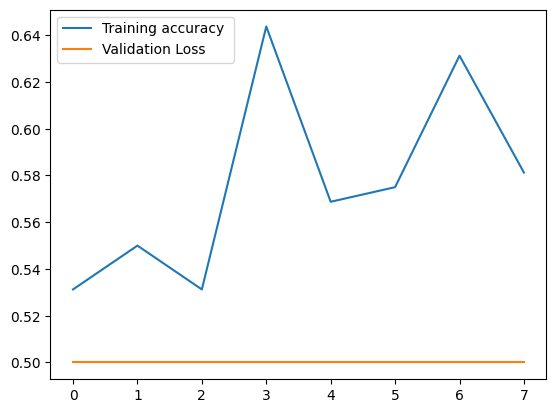

In [12]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training accuracy ")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [13]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [14]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [15]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - acc: 0.4742 - loss: 0.8062 - val_acc: 0.5250 - val_loss: 0.7102
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - acc: 0.4503 - loss: 0.7844 - val_acc: 0.5500 - val_loss: 0.6793
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - acc: 0.5368 - loss: 0.7561 - val_acc: 0.5500 - val_loss: 0.6534
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - acc: 0.5778 - loss: 0.7429 - val_acc: 0.5750 - val_loss: 0.6336
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - acc: 0.5623 - loss: 0.6775 - val_acc: 0.6000 - val_loss: 0.6165
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - acc: 0.6177 - loss: 0.6353 - val_acc: 0.6000 - val_loss: 0.6018
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - acc: 0.5834 - loss: 0.6989 - val_acc: 0.6250 - val_loss: 0.5892
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - acc: 0.5909 - loss: 0.6219 - val_acc: 0.6000 - val_loss: 0.5785


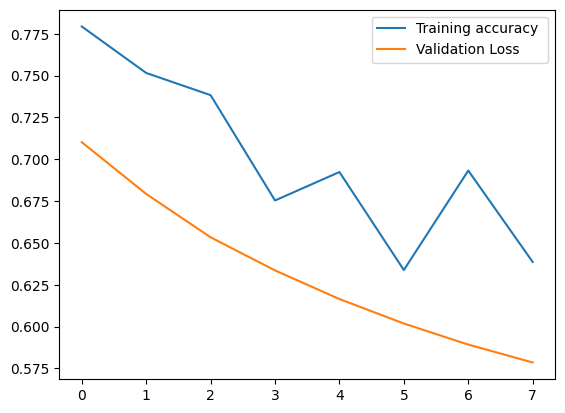

In [18]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training accuracy ")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

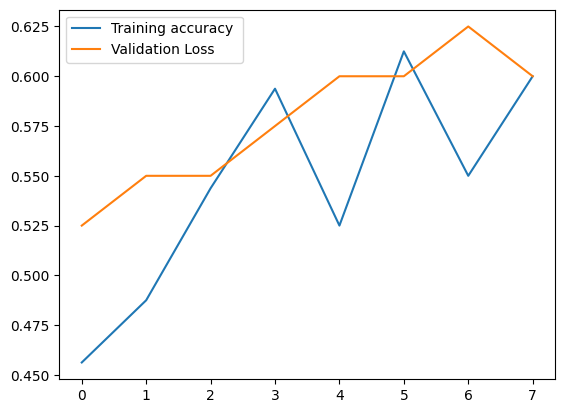

In [19]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training accuracy ")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [20]:
# Save the model
model.save('make_model_1.keras') # Use .keras or .h5 extension

# Load the model
loaded_model = keras.models.load_model('make_model_1.keras')